# Deep Residual Learning for Image Recognition: CIFAR-10 

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

from resnet import ResNet
from data_loader import get_data_loaders, plot_images
from utils import calculate_normalisation_params
from train import train


import warnings
warnings.filterwarnings('ignore')

In [3]:
# GLOBALS
# -----------------------

data_dir = 'data/cifar10'
batch_size = 128


## Data augmentation: Training set

Files already downloaded and verified
Files already downloaded and verified


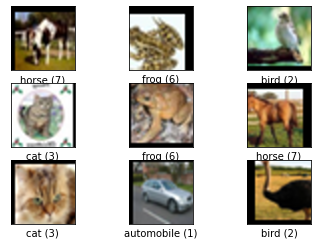

torch.Size([128, 3, 32, 32])


In [4]:
# VISUALISE
# -----------------------

# Load data without normalisations

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

The authors cite C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014. This paper suggests that 'corner cropping' should be used which could be interpretted one of two ways:

1. There are five possible crops for each image, centre and then four further crops with the crop placed tightly in each corner. This equates to `torchvision.transforms.FiveCrop()` in PyTorch.
2. The crop position is randomly selected from any possible position within the bounds of the padded image. Equivalent to `torchvision.transforms.RandomCrop()` in PyTorch.

The intended implementation seem ambiguous to me, so I implemented the latter here largely for simplicity.

## Data augmentation: Test set

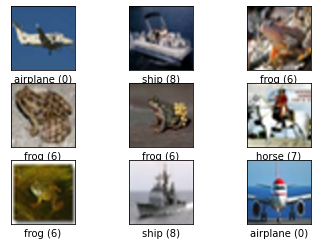

torch.Size([128, 3, 32, 32])


In [5]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

## Calculate normalisation parameters

The authors don't explicitly state if the images are normalised prior to training, however the paper referenced on preprocessing (C.-Y. Lee, S. Xie, P. Gallagher, Z. Zhang, and Z. Tu. Deeply-supervised nets. arXiv:1409.5185, 2014) notes that normalisation is used. 

I was unsure if the mean and standard deviation of the dataset should be calculated before or after augmentation for this purpose. It is also unclear if these calcualations should be done across the training and test set combined, or only the training set.

Her I've used the pre-transform training and test set combined.

In [6]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalisation

# Load data without transforms

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders(data_dir,
                                             batch_size,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)


# Takes a while to run so I've hardcoded results below

means, stds = calculate_normalisation_params(train_loader, test_loader)
print(f'means: {means}')
print(f'stds: {stds}')

Files already downloaded and verified
Files already downloaded and verified
means: [0.4918687901200942, 0.49185327461104705, 0.49183604204791675]
stds: [0.24697121702735994, 0.24696380162160952, 0.24697301067401806]


## Preprocessing

Here we finalise data augmentation and normalisation parameters ahead of training.

In [7]:
# SET FINAL TRANSFORMS WITH NORMALISATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.


# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

Notes:

- Note: downsampling with stride 2 results in uneven convolution, e.g. W_out is 16.5. Why didn't the authors use Maxpooling, would have been neater.

## Training

The authors report their results in term of training iterations. I've assumed an iteration here means a forwards and backwards pass of a batch of 128 observations through the entire network.

It seems more convenient to work in epochs in PyTorch, so here I calculate the integer number of iterations per epoch for later conversions. The results is 391 iterations per epoch. An epoch is a forwards and backwards pass for all observations in the training set.

In [8]:
# How many iterations in an epoch?

iterations = 0
for i, data in enumerate(train_loader, 0):
    iterations +=1
print(iterations)

391


### Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [9]:
# TRAINING PARAMETERS
# -------------------------

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 164

# OPTIMISER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

In [23]:
from utils2 import PreActBlock_MR
from MRresnet import PreActResNet_MR

train_loader, test_loader = get_data_loaders(data_dir,
                                            batch_size,
                                            train_transform,
                                            test_transform,
                                            shuffle=True,
                                            num_workers=4,
                                            pin_memory=True)
model = PreActResNet_MR(PreActBlock_MR)
criterion = torch.nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file ='results/PreActResNet_MR.csv'
model_file = 'pretrained/PreActResNet_MR.pt'
train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

Files already downloaded and verified
Files already downloaded and verified
cuda:0
Epoch 	Batch 	NLLLoss_Train
1 	50 	1.942
1 	100 	1.751
1 	150 	1.652
1 	200 	1.567
1 	250 	1.509
1 	300 	1.420
1 	350 	1.361
train_err: 0.49866 test_err: 0.5245
2 	50 	1.249
2 	100 	1.150
2 	150 	1.141
2 	200 	1.123
2 	250 	1.070
2 	300 	1.042
2 	350 	1.036
train_err: 0.44828 test_err: 0.4614
3 	50 	0.993
3 	100 	0.949
3 	150 	0.953
3 	200 	0.953
3 	250 	0.883
3 	300 	0.910
3 	350 	0.902
train_err: 0.31558 test_err: 0.327
4 	50 	0.858
4 	100 	0.865
4 	150 	0.869
4 	200 	0.798
4 	250 	0.811
4 	300 	0.817
4 	350 	0.763
train_err: 0.29116 test_err: 0.3025
5 	50 	0.737
5 	100 	0.781
5 	150 	0.736
5 	200 	0.745
5 	250 	0.720
5 	300 	0.754
5 	350 	0.700
train_err: 0.28502 test_err: 0.3065
6 	50 	0.678
6 	100 	0.695
6 	150 	0.693
6 	200 	0.658
6 	250 	0.664
6 	300 	0.697
6 	350 	0.673
train_err: 0.27982 test_err: 0.2919
7 	50 	0.630
7 	100 	0.649
7 	150 	0.650
7 	200 	0.610
7 	250 	0.669
7 	300 	0.629
7 	350 	0

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000201C66E9B88>
Traceback (most recent call last):
  File "C:\Users\Juan A. Figueroa\anaconda3\envs\dorn-trilobyte\lib\site-packages\torch\utils\data\dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "C:\Users\Juan A. Figueroa\anaconda3\envs\dorn-trilobyte\lib\site-packages\torch\utils\data\dataloader.py", line 1174, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


30 	50 	0.383
30 	100 	0.381
30 	150 	0.375
30 	200 	0.379
30 	250 	0.372
30 	300 	0.367
30 	350 	0.396
train_err: 0.1344 test_err: 0.1683
31 	50 	0.349
31 	100 	0.361
31 	150 	0.373
31 	200 	0.363
31 	250 	0.389
31 	300 	0.393
31 	350 	0.380
train_err: 0.13546 test_err: 0.1655
32 	50 	0.360
32 	100 	0.379
32 	150 	0.371
32 	200 	0.379
32 	250 	0.353
32 	300 	0.389
32 	350 	0.370
train_err: 0.14272 test_err: 0.1905
33 	50 	0.346
33 	100 	0.366
33 	150 	0.362
33 	200 	0.372
33 	250 	0.365
33 	300 	0.361
33 	350 	0.381
train_err: 0.11678 test_err: 0.148
34 	50 	0.341
34 	100 	0.360
34 	150 	0.383
34 	200 	0.376
34 	250 	0.369
34 	300 	0.372
34 	350 	0.354
train_err: 0.16028 test_err: 0.188
35 	50 	0.350
35 	100 	0.356
35 	150 	0.360
35 	200 	0.366
35 	250 	0.368
35 	300 	0.349
35 	350 	0.372
train_err: 0.14546 test_err: 0.1764
36 	50 	0.330
36 	100 	0.345
36 	150 	0.347
36 	200 	0.364
36 	250 	0.359
36 	300 	0.363
36 	350 	0.369
train_err: 0.13366 test_err: 0.1685
37 	50 	0.320
37 	100 	

train_err: 0.03402 test_err: 0.0963
89 	50 	0.128
89 	100 	0.128
89 	150 	0.131
89 	200 	0.132
89 	250 	0.124
89 	300 	0.128
89 	350 	0.136
train_err: 0.0319 test_err: 0.0965
90 	50 	0.126
90 	100 	0.126
90 	150 	0.126
90 	200 	0.119
90 	250 	0.127
90 	300 	0.123
90 	350 	0.125
train_err: 0.03174 test_err: 0.0978
91 	50 	0.114
91 	100 	0.128
91 	150 	0.114
91 	200 	0.119
91 	250 	0.129
91 	300 	0.129
91 	350 	0.124
train_err: 0.02916 test_err: 0.0953
92 	50 	0.108
92 	100 	0.122
92 	150 	0.114
92 	200 	0.126
92 	250 	0.113
92 	300 	0.122
92 	350 	0.120
train_err: 0.02862 test_err: 0.0983
93 	50 	0.111
93 	100 	0.108
93 	150 	0.119
93 	200 	0.110
93 	250 	0.116
93 	300 	0.119
93 	350 	0.112
train_err: 0.02814 test_err: 0.0975
94 	50 	0.111
94 	100 	0.117
94 	150 	0.115
94 	200 	0.115
94 	250 	0.123
94 	300 	0.106
94 	350 	0.110
train_err: 0.027 test_err: 0.0969
95 	50 	0.116
95 	100 	0.111
95 	150 	0.110
95 	200 	0.107
95 	250 	0.113
95 	300 	0.111
95 	350 	0.101
train_err: 0.0258 test_

145 	150 	0.049
145 	200 	0.054
145 	250 	0.052
145 	300 	0.048
145 	350 	0.056
train_err: 0.00794 test_err: 0.0929
146 	50 	0.050
146 	100 	0.051
146 	150 	0.052
146 	200 	0.051
146 	250 	0.050
146 	300 	0.052
146 	350 	0.050
train_err: 0.0079 test_err: 0.0931
147 	50 	0.048
147 	100 	0.056
147 	150 	0.050
147 	200 	0.052
147 	250 	0.052
147 	300 	0.053
147 	350 	0.056
train_err: 0.00742 test_err: 0.0943
148 	50 	0.049
148 	100 	0.047
148 	150 	0.055
148 	200 	0.050
148 	250 	0.046
148 	300 	0.044
148 	350 	0.049
train_err: 0.00796 test_err: 0.0932
149 	50 	0.050
149 	100 	0.052
149 	150 	0.050
149 	200 	0.057
149 	250 	0.048
149 	300 	0.046
149 	350 	0.051
train_err: 0.00814 test_err: 0.0935
150 	50 	0.047
150 	100 	0.050
150 	150 	0.050
150 	200 	0.046
150 	250 	0.055
150 	300 	0.055
150 	350 	0.050
train_err: 0.00758 test_err: 0.0933
151 	50 	0.049
151 	100 	0.052
151 	150 	0.047
151 	200 	0.051
151 	250 	0.050
151 	300 	0.050
151 	350 	0.049
train_err: 0.00696 test_err: 0.0949
152

PreActResNet_MR(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (layer1_left): Sequential(
    (0): PreActBlock_MR(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (layer1_right): Sequential(
    (0): PreActBlock_MR(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (shortcut_conv1): Conv2d(32, 32, kernel_size

In [24]:
from resnet import ResNet

train_loader, test_loader = get_data_loaders(data_dir,
                                            batch_size,
                                            train_transform,
                                            test_transform,
                                            shuffle=True,
                                            num_workers=4,
                                            pin_memory=True)

model = ResNet()
criterion = torch.nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file ='results/ResNet.csv'
model_file = 'pretrained/ResNet.pt'
train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

ImportError: cannot import name 'Resnet' from 'resnet' (D:\Research\FeatureExtractor\resnet.py)

In [ ]:
from mono_depth import MonoDepth

train_loader, test_loader = get_data_loaders(data_dir,
                                            batch_size,
                                            train_transform,
                                            test_transform,
                                            shuffle=True,
                                            num_workers=4,
                                            pin_memory=True)

model = MonoDepth()
criterion = torch.nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file ='results/MonoDepth80.csv'
model_file = 'pretrained/MonoDepth80.pt'
train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

### Plain nets

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [ ]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=False)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/plainnet{6*n+2}.csv'
    model_file = f'pretrained/plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

### Residual nets

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [ ]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'results/resnet{6*n+2}.csv'
    model_file = f'pretrained/resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

### Check model

Table 6. in the paper reports that the ResNet model with 20 layers should have 0.27 million trainable parameters. We reproduce that here.

It is noted elsewhere that the plain net should have the same number of parameters for the CIFAR10 experiment. This is because an identity mapping is used for the residual shortcuts, as opposed to a convolutional layer, an so there are no additional trainable parameters.

In [ ]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

The PyTorch model architecture for a 20 layer model.

In [ ]:
print(model)

## Analysis

### Merge and Run resnet

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

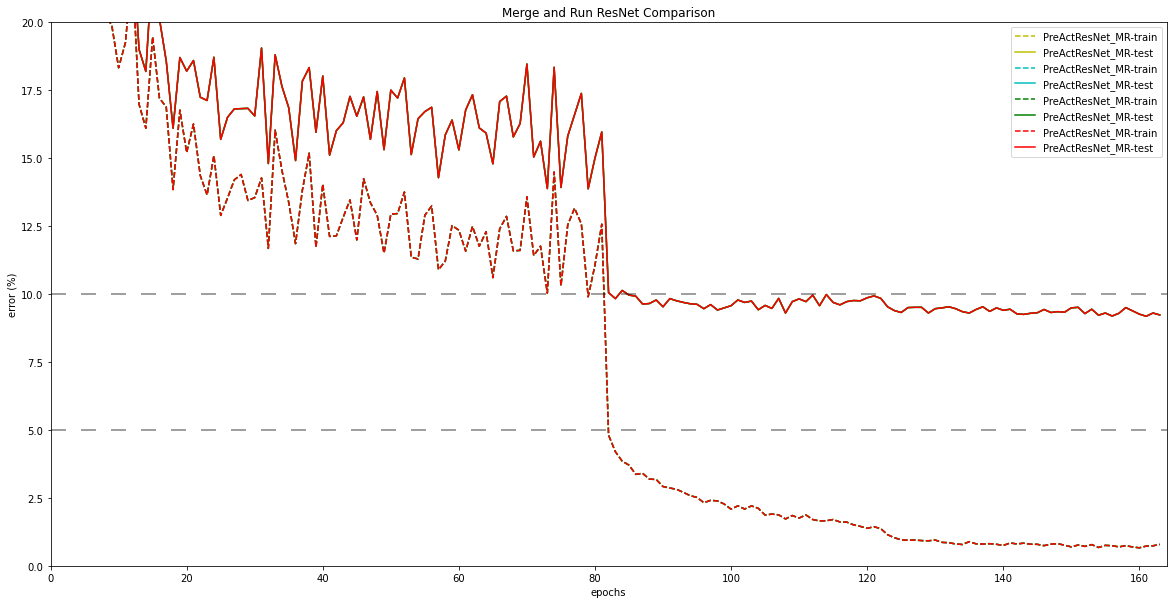

In [26]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


plainnet_dfs = [pd.read_csv(f'results/PreActResNet_MR.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'PreActResNet_MR-train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'PreActResNet_MR-test')

plt.title('Merge and Run ResNet Comparison')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [ ]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['PlainNet20', 'PlainNet32', 'PlainNet44', 'PlainNet56']
display(bests_df[['model', 'test_err']])

### Resnet

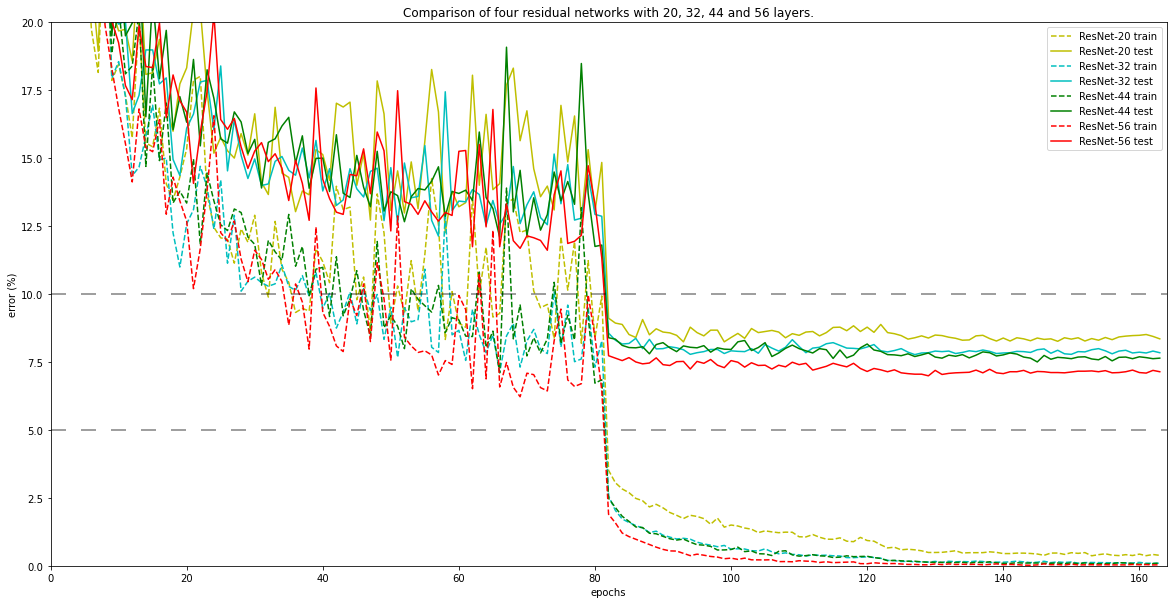

In [29]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']

resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 164, 0, 20])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));

In [30]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = ['ResNet20', 'ResNet32', 'ResNet44', 'ResNet56']
display(bests_df[['model', 'test_err']])


,model,test_err
93,ResNet20,0.0824
127,ResNet32,0.0777
145,ResNet44,0.0750
129,ResNet56,0.0699


## Side-by-side plot

ValueError: Unrecognized location 'bottom left'. Valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center


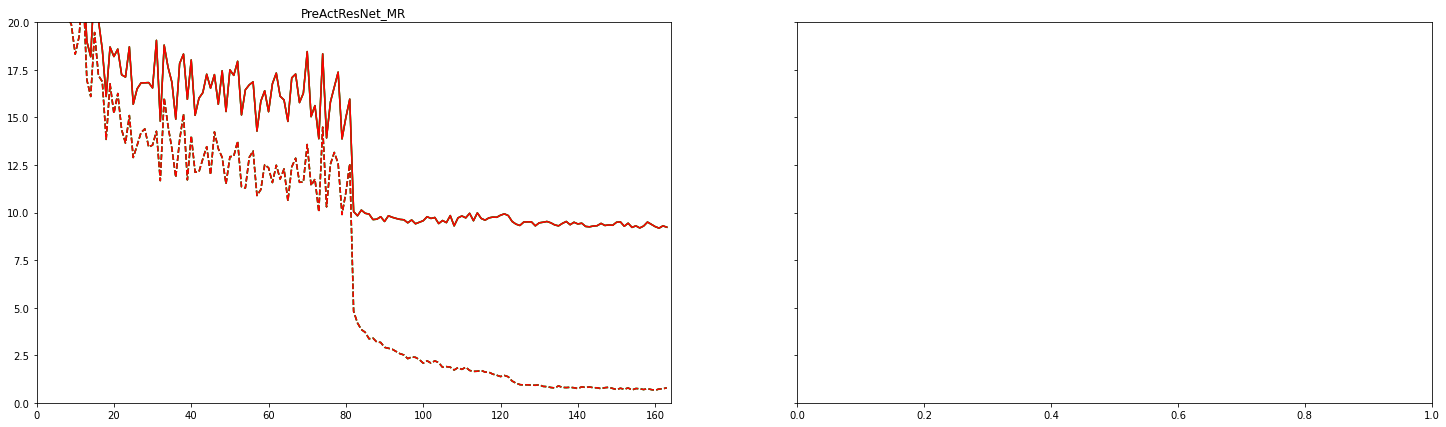

In [31]:
ns  = [3, 5, 7, 9]
clr = ['y', 'c', 'g', 'r']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'results/PreActResNet_MR.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'results/resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title):
    ax.axis([0, 164, 0, 20])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{clr[i]}--',
                 label=f'PreActResNet_MR-train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{clr[i]}',
                 label=f'PreActResNet_MR-test')
    
    ax.set_title(title)
    ax.legend(loc='bottom left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(10, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(5, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'PreActResNet_MR')
plot_results(resnet_dfs, ax2, 'Residual Networks')